In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os
import pynvml
from torch.profiler import record_function


In [ ]:
#Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#NVIDIA management library for VRAM monitoring
try:
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
except:
    gpu_handle = None

def get_vram_usage():
    if gpu_handle:
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        return mem_info.used / 1024**2  # MB
    return 0

In [ ]:
# Hyperparameters (adjusted for CIFAR-10 32x32, Appendix B)
T = 1000
BETA_START = 1e-4
BETA_END = 0.02
BATCH_SIZE = 32  
ACCUM_STEPS = 4  # Effective batch size = BATCH_SIZE * ACCUM_STEPS = 128. This is done to fit the model in 6GB VRAM
LEARNING_RATE = 2e-4  # CIFAR-10 setting
EPOCHS = 600  # Around 800k steps, like in the paper
EMA_DECAY = 0.9999
DROPOUT = 0.1  

In [ ]:
# Noise schedule (Section 2, Eq. 4)
def get_beta_schedule(timesteps, beta_start, beta_end):
    betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_alphas_cumprod": torch.sqrt(alphas_cumprod),
        "sqrt_one_minus_alphas_cumprod": torch.sqrt(1.0 - alphas_cumprod),
        "sigma": betas,
        "coeff1": betas / torch.sqrt(1.0 - alphas_cumprod),  
        "coeff2": 1.0 / torch.sqrt(alphas)  
    }

schedule_dict = get_beta_schedule(T, BETA_START, BETA_END)

In [ ]:
# Sinusoidal time embeddings
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)

In [7]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, dropout=0.0, use_attention=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.gn1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.gn2 = nn.GroupNorm(8, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.use_attention = use_attention
        if use_attention:
            self.attention = nn.MultiheadAttention(out_channels, num_heads=8)
    
    def forward(self, x, t):
        t_emb = F.silu(self.time_mlp(t))[:, :, None, None]
        h = F.silu(self.gn1(self.conv1(x)))
        h = h + t_emb
        h = F.silu(self.gn2(self.conv2(h)))
        h = self.dropout(h)
        if self.use_attention:
            b, c, h_dim, w = h.shape
            h_flat = h.view(b, c, -1).permute(2, 0, 1)
            h_flat, _ = self.attention(h_flat, h_flat, h_flat)
            h = h_flat.permute(1, 2, 0).view(b, c, h_dim, w)
        return h
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=64):
        super().__init__()
        self.time_emb = TimeEmbedding(time_dim)
        
        # Encoder (two blocks per level)
        self.inc1 = UNetBlock(in_channels, 96, time_dim, DROPOUT)
        self.inc2 = UNetBlock(96, 96, time_dim, DROPOUT)
        self.down1a = UNetBlock(96, 192, time_dim, DROPOUT)
        self.down1b = UNetBlock(192, 192, time_dim, DROPOUT)
        self.pool1 = nn.Conv2d(192, 192, 3, stride=2, padding=1)
        self.down2a = UNetBlock(192, 384, time_dim, DROPOUT)
        self.down2b = UNetBlock(384, 384, time_dim, DROPOUT)
        self.pool2 = nn.Conv2d(384, 384, 3, stride=2, padding=1)
        self.down3a = UNetBlock(384, 384, time_dim, DROPOUT)
        self.down3b = UNetBlock(384, 384, time_dim, DROPOUT)
        self.pool3 = nn.Conv2d(384, 384, 3, stride=2, padding=1)
        
        # Bottleneck (two blocks at 4x4)
        self.bottleneck1 = UNetBlock(384, 384, time_dim, DROPOUT)
        self.bottleneck2 = UNetBlock(384, 384, time_dim, DROPOUT)
        
        # Decoder (two blocks per level)
        self.up1 = nn.ConvTranspose2d(384, 384, 4, stride=2, padding=1)
        self.dec1a = UNetBlock(768, 384, time_dim, DROPOUT)  # 384+384=768
        self.dec1b = UNetBlock(384, 384, time_dim, DROPOUT)
        self.up2 = nn.ConvTranspose2d(384, 192, 4, stride=2, padding=1)
        self.dec2a = UNetBlock(384, 192, time_dim, DROPOUT, use_attention=True)  # 192+192=384
        self.dec2b = UNetBlock(192, 192, time_dim, DROPOUT)
        self.up3 = nn.ConvTranspose2d(192, 96, 4, stride=2, padding=1)
        self.dec3a = UNetBlock(192, 96, time_dim, DROPOUT)  # 96+96=192
        self.dec3b = UNetBlock(96, 96, time_dim, DROPOUT)
        self.out = nn.Conv2d(96, out_channels, 3, padding=1)
    
    def forward(self, x, t):
        t = self.time_emb(t)
        
        # Encoder
        x1 = self.inc1(x, t)  # 96 channels, 32x32
        x1 = self.inc2(x1, t)  # 96 channels, 32x32
        x2 = self.down1a(x1, t)  # 192 channels, 32x32
        x2 = self.down1b(x2, t)  # 192 channels, 32x32
        p1 = self.pool1(x2)  # 192 channels, 16x16
        x3 = self.down2a(p1, t)  # 384 channels, 16x16
        x3 = self.down2b(x3, t)  # 384 channels, 16x16
        p2 = self.pool2(x3)  # 384 channels, 8x8
        x4 = self.down3a(p2, t)  # 384 channels, 8x8
        x4 = self.down3b(x4, t)  # 384 channels, 8x8
        p3 = self.pool3(x4)  # 384 channels, 4x4
        
        # Bottleneck
        b = self.bottleneck1(p3, t)  # 384 channels, 4x4
        b = self.bottleneck2(b, t)  # 384 channels, 4x4
        
        # Decoder
        u1 = self.up1(b)  # 384 channels, 8x8
        d1 = self.dec1a(torch.cat([u1, p2], dim=1), t)  # Concat: 384+384=768 channels, 8x8
        d1 = self.dec1b(d1, t)  # 384 channels, 8x8
        u2 = self.up2(d1)  # 192 channels, 16x16
        d2 = self.dec2a(torch.cat([u2, p1], dim=1), t)  # Concat: 192+192=384 channels, 16x16
        d2 = self.dec2b(d2, t)  # 192 channels, 16x16
        u3 = self.up3(d2)  # 96 channels, 32x32
        d3 = self.dec3a(torch.cat([u3, x1], dim=1), t)  # Concat: 96+96=192 channels, 32x32
        d3 = self.dec3b(d3, t)  # 96 channels, 32x32
        return self.out(d3)  # 3 channels, 32x32

In [ ]:
class DiffusionModel:
    def __init__(self, model, schedule_dict):
        self.model = model.to(device)
        self.ema_model = UNet().to(device)
        self.ema_model.load_state_dict(model.state_dict())
        self.schedule_dict = schedule_dict
        self.optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        self.scaler = torch.amp.GradScaler()
    
    def forward_diffuse(self, x_0, t, noise):
        sqrt_alpha = self.schedule_dict["sqrt_alphas_cumprod"][t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.schedule_dict["sqrt_one_minus_alphas_cumprod"][t].reshape(-1, 1, 1, 1)
        return sqrt_alpha * x_0 + sqrt_one_minus_alpha * noise, noise
    
    @torch.no_grad()
    def sample(self, n_samples, img_channels=3, img_size=32, batch_size=100):
        try:
            print(f"Starting sampling: n_samples={n_samples}, VRAM: {get_vram_usage():.2f} MB")
            print(f"Checkpoint module: {torch.utils.checkpoint}")
            self.ema_model.eval()
            all_samples = []
            num_batches = (n_samples + batch_size - 1) // batch_size  

            for batch_idx in range(num_batches):
                current_batch_size = min(batch_size, n_samples - batch_idx * batch_size)
                x = torch.randn(current_batch_size, img_channels, img_size, img_size).to(device)
                for t in reversed(range(T)):
                    t_tensor = torch.full((current_batch_size,), t, device=device, dtype=torch.long)
                    with torch.amp.autocast('cuda'):
                        epsilon_pred = torch.utils.checkpoint.checkpoint(self.ema_model.forward, x, t_tensor, use_reentrant=False)
                    coeff1 = self.schedule_dict["coeff1"][t].reshape(-1, 1, 1, 1)
                    coeff2 = self.schedule_dict["coeff2"][t].reshape(-1, 1, 1, 1)
                    x = (x - coeff1 * epsilon_pred) * coeff2
                    if t > 0:
                        x += torch.sqrt(self.schedule_dict["sigma"][t]).reshape(-1, 1, 1, 1) * torch.randn_like(x)
                    if t % 200 == 0:
                        print(f"Sampling step {t}, Batch {batch_idx + 1}/{num_batches}, VRAM: {get_vram_usage():.2f} MB")
                all_samples.append(x.clamp(-1, 1))
            
            return torch.cat(all_samples, dim=0)
        except Exception as e:
            print(f"Sampling error: {str(e)}")
            raise
    
    def train_step(self, x_0, accum_steps=1):
        self.model.train()
        batch_size = x_0.size(0)
        t = torch.randint(0, T, (batch_size,), device=device)
        noise = torch.randn_like(x_0).to(device)
        
        with torch.amp.autocast('cuda'):
            x_t, epsilon = self.forward_diffuse(x_0, t, noise)
            epsilon_pred = self.model(x_t, t)
            loss = F.mse_loss(epsilon_pred, epsilon) / accum_steps
        
        self.scaler.scale(loss).backward()
        return loss.item() * accum_steps

    def optimize_step(self):
        self.scaler.unscale_(self.optimizer)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()
        
        # Update EMA
        for ema_param, param in zip(self.ema_model.parameters(), self.model.parameters()):
            ema_param.data = EMA_DECAY * ema_param.data + (1 - EMA_DECAY) * param.data

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

try:
    dataset = torchvision.datasets.CIFAR10(
        root="./data",
        train=True,
        download=False,
        transform=transform
    )
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error: {str(e)}")
    exit(1)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Dataset loaded successfully!


In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()
print("VRAM usage before training:", get_vram_usage(), "MB")

VRAM usage before training: 771.83984375 MB


In [ ]:
# Initialize model
model = UNet()
diffusion = DiffusionModel(model, schedule_dict)
param_count = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {param_count:,}")

# Setup output directories
timestamp = "20250505_191454"
os.makedirs(f"./samples_{timestamp}", exist_ok=True)
os.makedirs(f"./checkpoints_{timestamp}", exist_ok=True) # Checkpoints are used for resuming training, as training can take a long time on current hardware

# Verify directory permissions
try:
    with open(f"./samples_{timestamp}/test.txt", "w") as f:
        f.write("test")
    os.remove(f"./samples_{timestamp}/test.txt")
    print(f"Directory ./samples_{timestamp} is writable")
except Exception as e:
    print(f"Error: Cannot write to ./samples_{timestamp}: {str(e)}")
    exit(1)

try:
    with open(f"./checkpoints_{timestamp}/test.txt", "w") as f:
        f.write("test")
    os.remove(f"./checkpoints_{timestamp}/test.txt")
    print(f"Directory ./checkpoints_{timestamp} is writable")
except Exception as e:
    print(f"Error: Cannot write to ./checkpoints_{timestamp}: {str(e)}")
    exit(1)
    
# Load checkpoint if available
checkpoint_dir = f"./checkpoints_{timestamp}" 
checkpoint_path = None
start_epoch = 0
latest_epoch = -1
losses = []
    
# Find the latest checkpoint
for file in os.listdir(checkpoint_dir):
    if file.startswith("epoch_") and file.endswith(".pth"):
        try:
            epoch_num = int(file.split("_")[1].split(".")[0])
            if epoch_num > latest_epoch:
                latest_epoch = epoch_num
                checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch_num}.pth")
        except ValueError:
            continue

if checkpoint_path and latest_epoch >= 0:
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        diffusion.ema_model.load_state_dict(checkpoint["ema_model_state_dict"])
        diffusion.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        losses = checkpoint.get("losses", [])
        print(f"Loaded checkpoint: {checkpoint_path}, resuming from epoch {start_epoch}, loaded {len(losses)} loss values")
    except Exception as e:
        print(f"Error loading checkpoint {checkpoint_path}: {str(e)}")
        start_epoch = 0
        losses = []
else:
    print(f"No checkpoint found in {checkpoint_dir}. Starting from epoch 1.")

# Training loop with gradient accumulation

for epoch in range(start_epoch - 1, EPOCHS):
    total_loss = 0
    batch_idx = 0
    
    
    for x_0, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        with record_function("Data Loading"):
            x_0 = x_0.to(device)
        
        with record_function("Train Step"):
            loss = diffusion.train_step(x_0, accum_steps=ACCUM_STEPS)
        
        total_loss += loss
        
        # Apply optimizer step after ACCUM_STEPS
        if (batch_idx + 1) % ACCUM_STEPS == 0:
            with record_function("Optimize Step"):
                diffusion.optimize_step()
        
        
        batch_idx += 1
    
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    vram_usage = get_vram_usage()
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, VRAM: {vram_usage:.2f} MB")
    
    # Save samples and checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        try:
            with record_function("Sample Generation"):
                samples = diffusion.sample(n_samples=8)  
                samples = (samples + 1) / 2
                torchvision.utils.save_image(
                    samples,
                    f"./samples_{timestamp}/epoch_{epoch+1}.png",
                    nrow=4
                )
            print(f"Samples saved to ./samples_{timestamp}/epoch_{epoch+1}.png")
        except Exception as e:
            print(f"Sample generation error at epoch {epoch+1}: {str(e)}")
    
    if (epoch + 1) % 2 == 0:
        try:
            torch.save({
                "model_state_dict": model.state_dict(),
                "ema_model_state_dict": diffusion.ema_model.state_dict(),
                "optimizer_state_dict": diffusion.optimizer.state_dict(),
                "epoch": epoch,
                "losses": losses
            }, f"./checkpoints_{timestamp}/epoch_{epoch+1}.pth")
            print(f"Checkpoint saved to ./checkpoints_{timestamp}/epoch_{epoch+1}.pth")
        except Exception as e:
            print(f"Checkpoint saving error at epoch {epoch+1}: {str(e)}")
    
    # Plot loss
    try:
        plt.plot(losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.savefig(f"./samples_{timestamp}/loss_plot.png")
        plt.close()
        print(f"Loss plot saved to ./samples_{timestamp}/loss_plot.png")
    except Exception as e:
        print(f"Loss plot saving error: {str(e)}")

print("Training complete. To evaluate FID, use torch-fid:")
print("fid_score --gpu 0 --batch-size 64 ./samples_{timestamp}/epoch_100.png ./data/cifar10_test")

Model parameters: 32,655,651
Directory ./samples_20250505_191454 is writable
Directory ./checkpoints_20250505_191454 is writable


KeyboardInterrupt: 

In [ ]:
# This cell is for saving the CIFAR-10 train images as PNG files, for FID evaluation.

transform = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),  # Undo the normalization from [-1, 1] to [0, 1]
    transforms.ToPILImage()
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,  # Test set
    download=False,
    transform=transforms.ToTensor()
)

# Create a directory to save test images
os.makedirs("./data/cifar10_png", exist_ok=True)

# Save test images as PNG files
for idx, (image, _) in enumerate(train_dataset):
    image = transform(image)  
    image.save(f"./data/cifar10_png/{idx}.png")
print("CIFAR-10 test images saved to ./data/cifar10_png")

CIFAR-10 test images saved to ./data/cifar10_png


In [ ]:
# This cell is for generating samples after training.



model = UNet()
diffusion = DiffusionModel(model, schedule_dict)


import os
# Setup output directories
start_epoch = 0
latest_epoch = -1
timestamp = "20250505_191454"
checkpoint_dir = f"./checkpoints_{timestamp}"  # Update to your existing timestamp
for file in os.listdir(checkpoint_dir):
    if file.startswith("epoch_") and file.endswith(".pth"):
        try:
            epoch_num = int(file.split("_")[1].split(".")[0])
            if epoch_num > latest_epoch:
                latest_epoch = epoch_num
                checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch_num}.pth")
        except ValueError:
            continue
        
if checkpoint_path and latest_epoch >= 0:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    diffusion.ema_model.load_state_dict(checkpoint["ema_model_state_dict"])
    diffusion.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    

samples = diffusion.sample(n_samples=5000, img_channels=3, img_size=32, batch_size=100)
samples = (samples + 1) / 2  # Rescale from [-1, 1] to [0, 1]

# Save individual images
gen_dir = "./samples_20250505_191454/epoch_600_large"
os.makedirs(gen_dir, exist_ok=True)
for idx, sample in enumerate(samples):
    torchvision.utils.save_image(sample, f"{gen_dir}/{idx}.png")
print(f"Saved 5000 generated images to {gen_dir}")

Starting sampling: n_samples=5000, VRAM: 1720.77 MB
Checkpoint module: <module 'torch.utils.checkpoint' from 'c:\\Users\\mimo6\\Deep_learning\\DL\\lib\\site-packages\\torch\\utils\\checkpoint.py'>
Sampling step 800, Batch 1/50, VRAM: 5018.83 MB
Sampling step 600, Batch 1/50, VRAM: 5018.71 MB
Sampling step 400, Batch 1/50, VRAM: 5014.96 MB
Sampling step 200, Batch 1/50, VRAM: 5014.46 MB
Sampling step 0, Batch 1/50, VRAM: 5029.51 MB
Sampling step 800, Batch 2/50, VRAM: 5029.51 MB
Sampling step 600, Batch 2/50, VRAM: 5029.51 MB
Sampling step 400, Batch 2/50, VRAM: 5029.51 MB
Sampling step 200, Batch 2/50, VRAM: 5031.01 MB
Sampling step 0, Batch 2/50, VRAM: 5030.89 MB
Sampling step 800, Batch 3/50, VRAM: 5030.89 MB
Sampling step 600, Batch 3/50, VRAM: 5030.89 MB
Sampling step 400, Batch 3/50, VRAM: 5030.89 MB
Sampling step 200, Batch 3/50, VRAM: 5030.89 MB
Sampling step 0, Batch 3/50, VRAM: 5018.51 MB
Sampling step 800, Batch 4/50, VRAM: 5018.39 MB
Sampling step 600, Batch 4/50, VRAM: 5026

In [ ]:
# FID evaluation

import torch
from pytorch_fid import fid_score
import pathlib

# Define paths to the directories
path_to_generated = pathlib.Path("./samples_20250505_191454/epoch_600_large")
path_to_real = pathlib.Path("./data/cifar10_png")
path_to_generated_str = str(path_to_generated)
path_to_real_str = str(path_to_real)

# Calculate FID
fid_value = fid_score.calculate_fid_given_paths(
    paths=[path_to_generated_str, path_to_real_str],
    batch_size=64,  # Adjust based on your GPU memory
    device="cuda" if torch.cuda.is_available() else "cpu",
    dims=2048  # Using InceptionV3's default feature dimension
)

print(f"FID Score: {fid_value}")

100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


FID Score: 50.44676769950706


No images loaded. Check file paths and names.


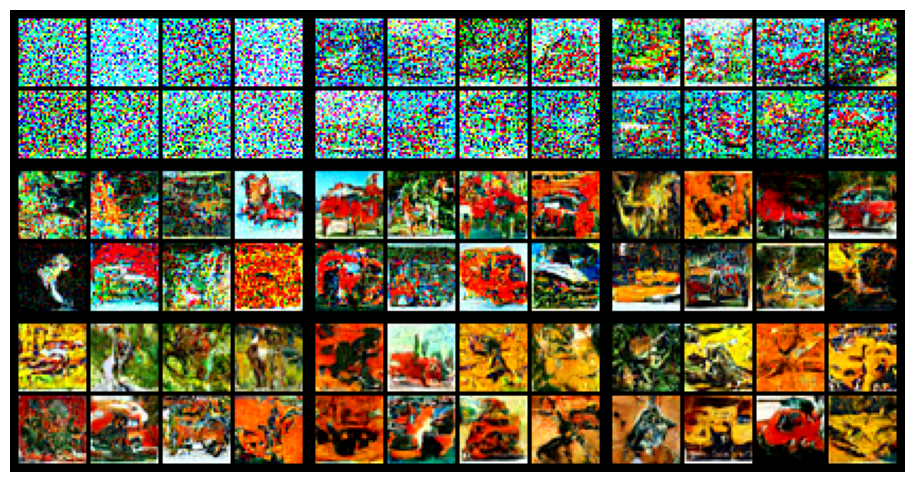

In [ ]:
# Visualize generated samples from various epochs

import os
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


sample_dir = r"samples_20250505_191454"  
checkpoints = [60, 65, 70, 75, 80, 85, 90, 95, 100] 


all_images = []
epoch_positions = []


transform = transforms.ToTensor()  

for idx, epoch in enumerate(checkpoints):
    img_path = os.path.join(sample_dir, f"epoch_{epoch}.png")
    if os.path.exists(img_path):
        img = plt.imread(img_path)  
        img_tensor = transform(img).unsqueeze(0) 
        all_images.append(img_tensor)
        epoch_positions.append(idx)  
    else:
        print(f"Warning: {img_path} not found, skipping.")

# Stack images into a single grid
if all_images:
    grid = make_grid(torch.cat(all_images, dim=0), nrow=3, padding=2, normalize=True)
    num_checkpoints = len(checkpoints)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy())
    ax.axis("off")
    plt.savefig(f"{sample_dir}/epoch_samples.png")
else:
    print("No images loaded. Check file paths and names.")

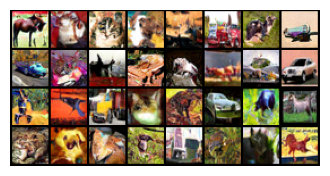

In [ ]:
# Visualize generated samples from the last epoch


sample_dir = r"samples_20250505_191454"  
last_epoch_images = []

for i in range(32):
    img_path = os.path.join(sample_dir, f"epoch_600_large/{i}.png")
    if os.path.exists(img_path):
        img = plt.imread(img_path)
        img_tensor = transform(img).unsqueeze(0)
        last_epoch_images.append(img_tensor)
if last_epoch_images:
    grid = make_grid(torch.cat(last_epoch_images, dim=0), nrow=8, padding=2, normalize=True)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy())
    ax.axis("off")
    plt.savefig("last_epoch_samples.png", bbox_inches="tight", dpi=300)
    plt.show()